In [1]:
import torch

In [2]:
# |export tensor_gates.functional
from itertools import product


def identity_gate_tensor(
    num_qubits: int,
    matrix_form: bool,
    *,
    dtype: torch.dtype | None = None,
    device: torch.device | None = None,
    _fast_mode: bool = True,
) -> torch.Tensor:
    """
    Create a tensor representation of the identity gate.

    Args:
        num_qubits: int, the number of qubits.
        matrix_form: bool, whether to return the matrix form of the identity gate.
        dtype: torch.dtype | None, the dtype of the identity gate tensor.
        device: torch.device | None, the device of the identity gate tensor.
    Returns:
        torch.Tensor, the identity gate tensor.
    """
    if matrix_form:
        return torch.eye(2**num_qubits, dtype=dtype, device=device)
    elif _fast_mode:
        matrix = torch.eye(2**num_qubits, dtype=dtype, device=device)
        return matrix.view([2] * (num_qubits * 2))
    else:
        tensor = torch.zeros([2] * (num_qubits * 2), dtype=dtype, device=device)
        for i in product([0, 1], repeat=num_qubits):
            indices = i + i
            tensor[indices] = 1
        return tensor

In [3]:
# Test
num_qubits = 4
dtype = torch.float32
device = torch.device("cpu")
i0 = identity_gate_tensor(num_qubits, False, dtype=dtype, device=device, _fast_mode=True)
i1 = identity_gate_tensor(num_qubits, False, dtype=dtype, device=device, _fast_mode=False)
assert torch.allclose(i0, i1)

In [4]:
# |export tensor_gates.functional
from tensor_network.utils.checking import check_quantum_gate


def get_control_gate_tensor(
    num_control_qubits: int,
    applied_gate: torch.Tensor,
    matrix_form: bool,
    *,
    dtype: torch.dtype,
    device: torch.device,
    _fast_mode: bool = True,
) -> torch.Tensor:
    """
    Create a tensor representation of a controlled gate.

    Args:
        num_control_qubits: int, the number of control qubits.
        applied_gate: torch.Tensor, the gate to be applied.
        matrix_form: bool, whether to return the matrix form of the controlled gate.
        dtype: torch.dtype, the dtype of the controlled gate tensor.
        device: torch.device, the device of the controlled gate tensor.
    Returns:
        torch.Tensor, the controlled gate tensor.
    """
    num_applied_qubits = check_quantum_gate(applied_gate)
    num_total_qubits = num_control_qubits + num_applied_qubits
    if matrix_form or _fast_mode:
        if applied_gate.ndim > 2:
            applied_gate = applied_gate.view(2**num_applied_qubits, 2**num_applied_qubits)
        matrix = identity_gate_tensor(
            num_total_qubits, True, dtype=dtype, device=device, _fast_mode=_fast_mode
        )
        slice_start = (2**num_control_qubits - 1) << num_applied_qubits
        matrix[slice_start:, slice_start:] = applied_gate
        if matrix_form:
            return matrix
        else:
            return matrix.view([2] * (num_total_qubits * 2))
    else:
        tensor = identity_gate_tensor(
            num_total_qubits, False, dtype=dtype, device=device, _fast_mode=False
        )
        applied_gate = applied_gate.view([2] * (num_applied_qubits * 2))
        index = [1] * num_control_qubits + [slice(None, None, None)] * num_applied_qubits
        index = index + index
        tensor[index] = applied_gate
        return tensor

In [5]:
# |export tensor_gates.functional
def rand_unitary(
    dim: int, *, dtype: torch.dtype | None = None, device: torch.device | None = None
) -> torch.Tensor:
    """
    Generate a random unitary matrix of given dimension.

    Args:
        dim (int): Dimension of the matrix.
    Returns:
        torch.Tensor: A random unitary matrix of the specified dimension.
    """
    mat = torch.randn(dim, dim, dtype=dtype, device=device)
    Q, _R = torch.linalg.qr(mat)
    return Q


def rand_gate_tensor(
    num_qubits: int,
    matrix_form: bool,
    *,
    dtype: torch.dtype | None = None,
    device: torch.device | None = None,
) -> torch.Tensor:
    """
    Generate a random gate tensor of given dimension.

    Args:
        num_qubits (int): Number of qubits.
        matrix_form (bool): Whether to return the matrix form of the gate.
    Returns:
        torch.Tensor: A random gate tensor of the specified qubit number.
    """
    mat_dim = 2**num_qubits
    mat = rand_unitary(mat_dim, dtype=dtype, device=device)
    if matrix_form:
        return mat
    else:
        return mat.view([2] * (num_qubits * 2))

In [6]:
from tensor_network.utils.mapping import view_gate_matrix_as_tensor

dtype = torch.float32
device = torch.device("cpu")

for _ in range(10):
    applied_gate = rand_gate_tensor(2, False, dtype=dtype, device=device)
    control_gate_fast = get_control_gate_tensor(
        2, applied_gate, False, dtype=dtype, device=device, _fast_mode=True
    )
    control_gate_slow = get_control_gate_tensor(
        2, applied_gate, False, dtype=dtype, device=device, _fast_mode=False
    )
    control_gate_mat = get_control_gate_tensor(2, applied_gate, True, dtype=dtype, device=device)
    assert torch.allclose(control_gate_fast, control_gate_slow)
    assert torch.allclose(control_gate_fast, view_gate_matrix_as_tensor(control_gate_mat))

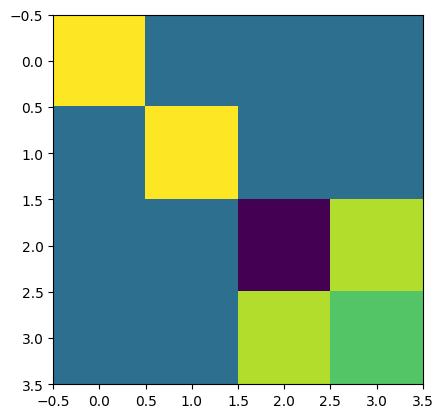

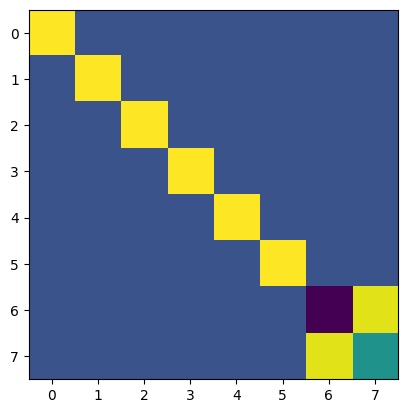

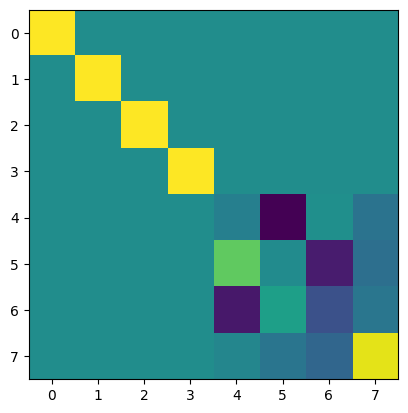

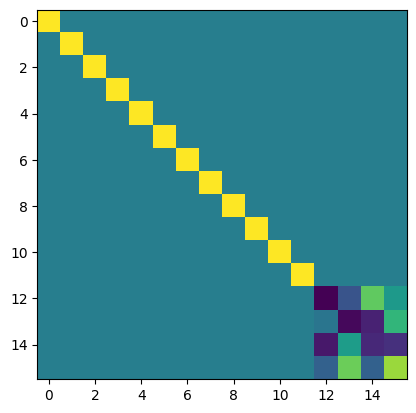

In [ ]:
import matplotlib.pyplot as plt

# plot patterns
for i in range(1, 3):
    for j in range(1, 3):
        applied_gate = rand_gate_tensor(i, False, dtype=dtype, device=device)
        control_gate_mat = get_control_gate_tensor(
            j, applied_gate, True, dtype=dtype, device=device
        )
        plt.imshow(control_gate_mat)
        plt.show()